<span style="font-family: calibre;font-size:3em">Visão Geral </span>

 <p style='font-family:calibre; font-size:14pt' >
    <b>Assunto: </b> Acidentes de trânsito em rodovias federais <br>
    <b>Base: </b>Informação dos acidentes agrupados por ocorrência ou por pessoa <br>
    <b>Dados disponiveis em : </b> 
    <a href='https://portal.prf.gov.br/dados-abertos-acidentes'>Acidentes - Policia Rodoviaria Federal - PRF</a><br>
    <b>Dicionário de dados disponiveis em : </b> 
    <a href='https://arquivos.prf.gov.br/arquivos/index.php/s/mheQDcXUx2veHnU'>Dicionário de Dados - Policia Rodoviaria Federal - PRF</a><br>
    <b>Periodo Disponível:</b>2007 a 05/2020. Mas devido a atualização de campos da base em 2017,incluindo latitude e longitute que é nossa chave de ligação com os pontos de parada, usuremos a partir desse periodo. <br>
</p>

## Preparação de Dados

### 1. Import de dados 

In [1]:
#Imports de Bibliotecas a serem utilizadas
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
# Transfomacao
from scipy import stats
# for min_max scaling
from sklearn.preprocessing import StandardScaler, MinMaxScaler
# plotting 
from scipy import stats, integrate
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LinearRegression
import math
from scipy import stats
%matplotlib inline

### 2. Salvar dados na estrutura de Dicionario

In [2]:
#Salva Dados em estrutura de dicionario
dic_dados = {}
for i in range(2017,2021):
    base = 'acidentes'+str(i)
    dados =str('data_'+str(i))
    dados= pd.read_csv("data/acidentes/"+base+".csv", encoding = 'latin1', sep = ";",parse_dates=['data_inversa'])
#Identificar o ano
    dados['Base'] = base
    dic_dados[base]=dados

### 3. Une todas bases

In [3]:
#Unir todas bases
new_data =pd.concat([dic_dados['acidentes2017'],
                      dic_dados['acidentes2018'],
                      dic_dados['acidentes2019'],
                      dic_dados['acidentes2020']], ignore_index=True)

In [4]:
#Identificar colunas do tipo texto (object)
df_string = new_data.select_dtypes(include = object)
cols_string = df_string.columns.tolist()
#transformar todos os campos de texto em minusculo e sem espaço
for i in cols_string:
    new_data[i] = new_data[i].str.strip()
    new_data[i] = new_data[i].str.lower()

### 4. Filtros de acidentes apenas de caminhoneiros

In [5]:
df_filtro = new_data[new_data['tipo_veiculo'].str.contains('cami')]

In [6]:
# tipos de Veiculos em Relação a base
filtro = pd.DataFrame(df_filtro['tipo_veiculo'].value_counts())
filtro['freq'] = (filtro['tipo_veiculo']/len(new_data))*100
filtro = filtro.reset_index()
filtro.columns = ['Tipo_Veiculo','Frequencia Absoluta','Frequencia Relativa']
filtro

,Tipo_Veiculo,Frequencia Absoluta,Frequencia Relativa
0,caminhonete,51892,8.981677
1,caminhão-trator,46056,7.971559
2,caminhão,42050,7.278184
3,camioneta,14823,2.565625


In [7]:
## Tamanho da base Filtrada
df_filtro.head()

,id,pesid,data_inversa,dia_semana,horario,uf,br,km,municipio,causa_acidente,...,ilesos,feridos_leves,feridos_graves,mortos,latitude,longitude,regional,delegacia,uop,Base
16,17.0,15.0,2017-01-01,domingo,01:45:00,rs,116.0,"34,9",vacaria,defeito mecânico no veículo,...,1,0,0,0,"-28,5071196","-50,941176",sr-rs,del9/5,uop03/rs,acidentes2017
25,20.0,1541.0,2017-01-01,domingo,01:00:00,pr,376.0,636,tijucas do sul,velocidade incompatível,...,1,0,0,0,"-25,754","-49,1266",sr-pr,del7/1,uop08/pr,acidentes2017
37,28.0,1902.0,2017-01-01,domingo,01:25:00,ms,163.0,488,campo grande,restrição de visibilidade,...,0,1,0,0,"-20,4311","-54,5442",sr-ms,del3/1,uop02/ms,acidentes2017
43,31.0,5.0,2017-01-01,domingo,01:30:00,pr,277.0,"507,7",guaraniacu,ingestão de álcool,...,1,0,0,0,"-25,12401148","-52,75825918",sr-pr,del7/4,uop02/pr,acidentes2017
82,55.0,1086.0,2017-01-01,domingo,03:30:00,pa,316.0,178,santa luzia do para,desobediência às normas de trânsito pelo condutor,...,1,0,0,0,"-1,40029019","-47,01151192",sr-pa,del19/1,uop03/pa,acidentes2017


### 5. Valores Missing

In [8]:
df_filtro.isnull().sum()[df_filtro.isnull().sum()>0]

br                          227
km                          227
marca                      5359
ano_fabricacao_veiculo     5913
idade                     13076
uop                        6672
dtype: int64

### 6. Transformação e escolha das Variaveis 

#### 6.1 Transformação da variavel 'ano_fabricacao_veiculo' para condicao_veiculo

In [9]:
# Substituindo valores ausentes por 0
df_filtro['ano_fabricacao_veiculo'] = df_filtro['ano_fabricacao_veiculo'].fillna(0)
#Transformando campo para inteiro
df_filtro['ano_fabricacao_veiculo'] = df_filtro['ano_fabricacao_veiculo'].astype(int)
df_filtro['ano'] = df_filtro['data_inversa'].astype(str).str[0:4]
# Definindo a idade do veiculo no periodo
df_filtro['idade_veiculo'] = (df_filtro['data_inversa'].astype(str).str[0:4]).astype(int) - df_filtro['ano_fabricacao_veiculo']

df_filtro ['condicao_veiculo'] = 'ND'
df_filtro.loc[((df_filtro['ano_fabricacao_veiculo']!=0 ) & (df_filtro ['idade']>0)), 'condicao_veiculo'] = 'Velho'
df_filtro.loc[((df_filtro['ano_fabricacao_veiculo']!=0 ) & (df_filtro ['idade']<0)), 'condicao_veiculo'] = 'Novo'

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  after removing the cwd from sys.path.
C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documen

#### 6.2 Unindo BR e KM para criar chave única

In [10]:
df_filtro = df_filtro[~df_filtro.br.isnull()]

In [11]:
df_filtro.isnull().sum()[df_filtro.isnull().sum()>0]

marca     5354
idade    13044
uop       6639
dtype: int64

In [12]:
df_filtro['br'] = df_filtro['br'].astype(int)

In [13]:
df_filtro['km'] = df_filtro['km'].str.replace(',','.')
df_filtro['km'] = df_filtro['km'].astype(float)
df_filtro['km'] = df_filtro['km'].astype(int)

In [14]:
df_filtro['km'].head(2)

16     34
25    636
Name: km, dtype: int32

In [15]:
df_filtro ['br_km'] = df_filtro['br'].astype(str)+"_"+df_filtro ['km'].astype(str)

In [16]:
#Colunas
df_filtro.columns

Index(['id', 'pesid', 'data_inversa', 'dia_semana', 'horario', 'uf', 'br',
       'km', 'municipio', 'causa_acidente', 'tipo_acidente',
       'classificacao_acidente', 'fase_dia', 'sentido_via',
       'condicao_metereologica', 'tipo_pista', 'tracado_via', 'uso_solo',
       'id_veiculo', 'tipo_veiculo', 'marca', 'ano_fabricacao_veiculo',
       'tipo_envolvido', 'estado_fisico', 'idade', 'sexo', 'ilesos',
       'feridos_leves', 'feridos_graves', 'mortos', 'latitude', 'longitude',
       'regional', 'delegacia', 'uop', 'Base', 'ano', 'idade_veiculo',
       'condicao_veiculo', 'br_km'],
      dtype='object')

#### 6.1 Variaveis escolhidas como índices, ou seja que identificam o local do ponto de parada

In [17]:
indices = ['uf', 'municipio','br_km','latitude', 'longitude','regional', 'delegacia', 'uop']

In [18]:
chave_primária = ['br_km']

In [19]:
variaveis = ['ano','dia_semana','tipo_acidente','classificacao_acidente','fase_dia','sentido_via','condicao_metereologica','tipo_pista','tipo_envolvido','tracado_via','uso_solo']

In [20]:
colunas = chave_primária + variaveis

In [21]:
df_prep = df_filtro[colunas].set_index(['br_km'])

In [22]:
df_prep.head(2)

,ano,dia_semana,tipo_acidente,classificacao_acidente,fase_dia,sentido_via,condicao_metereologica,tipo_pista,tipo_envolvido,tracado_via,uso_solo
br_km,,,,,,,,,,,
116_34,2017,domingo,colisão traseira,com vítimas feridas,plena noite,decrescente,céu claro,simples,condutor,reta,não
376_636,2017,domingo,saída de leito carroçável,com vítimas fatais,plena noite,crescente,garoa/chuvisco,dupla,condutor,curva,não


In [23]:
df_prep.isnull().sum()

ano                       0
dia_semana                0
tipo_acidente             0
classificacao_acidente    0
fase_dia                  0
sentido_via               0
condicao_metereologica    0
tipo_pista                0
tipo_envolvido            0
tracado_via               0
uso_solo                  0
dtype: int64

### 7. Análises Descritivas da Base (EDA) 

#### 7.1 Estado físico

In [24]:
df_filtro['estado_fisico'].value_counts()

ileso            97834
lesões leves     34575
lesões graves     9104
não informado     8791
óbito             4290
Name: estado_fisico, dtype: int64

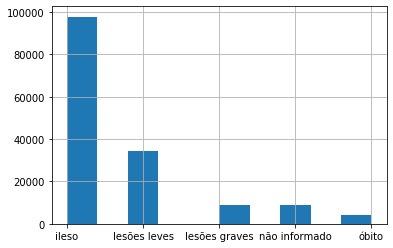

In [25]:
df_filtro['estado_fisico'].hist()

#### 7.2 Envolvidos

In [26]:
df_filtro['tipo_envolvido'].value_counts()

condutor      121107
passageiro     26941
testemunha      3554
pedestre        2934
cavaleiro         58
Name: tipo_envolvido, dtype: int64

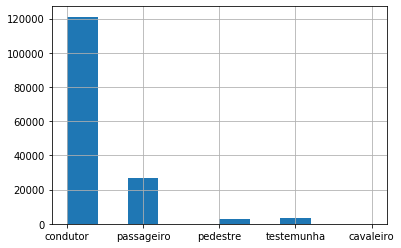

In [27]:
df_filtro['tipo_envolvido'].hist()

#### 7.3 Classificação do Acidente

In [28]:
df_filtro['classificacao_acidente'].value_counts()

com vítimas feridas    93512
sem vítimas            44929
com vítimas fatais     16153
Name: classificacao_acidente, dtype: int64

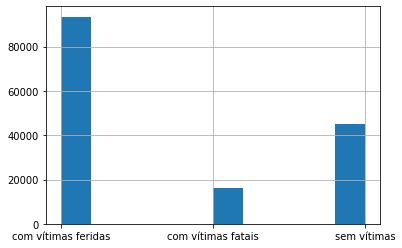

In [29]:
df_filtro['classificacao_acidente'].hist()

#### 7.4 Tipo do Acidente

In [30]:
df_filtro['tipo_acidente'].value_counts()

colisão traseira                   36202
saída de leito carroçável          21728
colisão lateral                    21639
colisão transversal                16497
colisão frontal                    14968
tombamento                         12077
colisão com objeto estático         7726
atropelamento de pedestre           6304
capotamento                         5177
engavetamento                       4892
incêndio                            2213
atropelamento de animal             1827
colisão com objeto em movimento     1014
derramamento de carga               1005
queda de ocupante de veículo         694
danos eventuais                      631
Name: tipo_acidente, dtype: int64

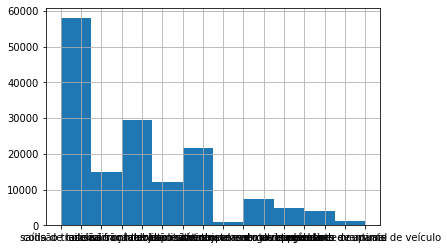

In [31]:
df_filtro['tipo_acidente'].hist()

#### 7.5 Causa do Acidente

In [32]:
df_filtro['causa_acidente'].value_counts()

falta de atenção à condução                                                       55020
velocidade incompatível                                                           17550
desobediência às normas de trânsito pelo condutor                                 13276
não guardar distância de segurança                                                11126
defeito mecânico no veículo                                                       10446
ingestão de álcool                                                                 8099
condutor dormindo                                                                  7966
pista escorregadia                                                                 5929
ultrapassagem indevida                                                             5020
falta de atenção do pedestre                                                       4100
animais na pista                                                                   2587
defeito na via                  

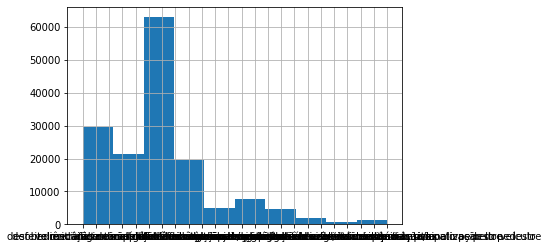

In [33]:
df_filtro['causa_acidente'].hist()

#### 7.5 Causa do Acidente

In [34]:
corr = df_filtro.corr()
corr

,id,pesid,br,km,id_veiculo,ano_fabricacao_veiculo,idade,ilesos,feridos_leves,feridos_graves,mortos,idade_veiculo
id,1.000000,0.999875,0.006640,-0.012192,0.999976,-0.015736,-0.003003,-0.087666,0.051995,0.036165,0.017594,0.018122
pesid,0.999875,1.000000,0.006486,-0.012323,0.999912,-0.015976,-0.002959,-0.087661,0.051964,0.036142,0.017111,0.018368
br,0.006640,0.006486,1.000000,0.048299,0.006554,0.012053,0.000239,-0.006293,0.006604,0.002237,0.002159,-0.012035
km,-0.012192,-0.012323,0.048299,1.000000,-0.012231,0.027003,-0.004540,-0.033074,0.033577,0.007047,0.013028,-0.027029
id_veiculo,0.999976,0.999912,0.006554,-0.012231,1.000000,-0.016152,-0.002998,-0.087689,0.051926,0.036137,0.017529,0.018539
ano_fabricacao_veiculo,-0.015736,-0.015976,0.012053,0.027003,-0.016152,1.000000,-0.006575,0.138535,0.092113,0.022277,-0.026944,-0.999997
idade,-0.003003,-0.002959,0.000239,-0.004540,-0.002998,-0.006575,1.000000,-0.005587,-0.002801,0.012129,0.005339,0.006564
ilesos,-0.087666,-0.087661,-0.006293,-0.033074,-0.087689,0.138535,-0.005587,1.000000,-0.704660,-0.328415,-0.221803,-0.138738
feridos_leves,0.051995,0.051964,0.006604,0.033577,0.051926,0.092113,-0.002801,-0.704660,1.000000,-0.134263,-0.090677,-0.091981
feridos_graves,0.036165,0.036142,0.002237,0.007047,0.036137,0.022277,0.012129,-0.328415,-0.134263,1.000000,-0.042261,-0.022197


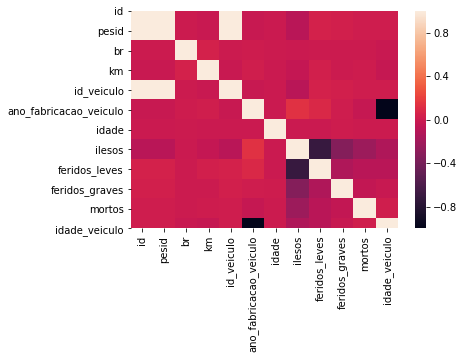

In [35]:
sns.heatmap(corr)

### 8. Export da Base

In [36]:
df_prep.to_csv('resultados/base_acidentes_prep.csv',index=False)